# Fashion MNIST

## Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import copy
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from os import listdir 

import torch
import torchvision
import torchvision.models as models
import torch.nn.functional as F

from torch import optim, nn
from torchvision import transforms, datasets
from torch.autograd import Variable

from itertools import chain 
from PIL import Image, ImageOps
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))

Tesla T4


## Image Preparation

In [4]:
BATCH_SIZE = 100

### Transformer

In [5]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

validation_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

### Download Data

In [6]:
train_data = datasets.FashionMNIST(
    'FashionMNIST_data',
    train=True,
    download=True,
    transform=train_transformer
)

validation_data = datasets.FashionMNIST(
    'FashionMNIST_data',
    train=False,
    download=True,
    transform=validation_transformer
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST_data/FashionMNIST/raw



In [7]:
data_size = len(train_data), len(validation_data)
data_size

(60000, 10000)

### Data Loader

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE
)

validation_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=BATCH_SIZE
)

## Show Some Images

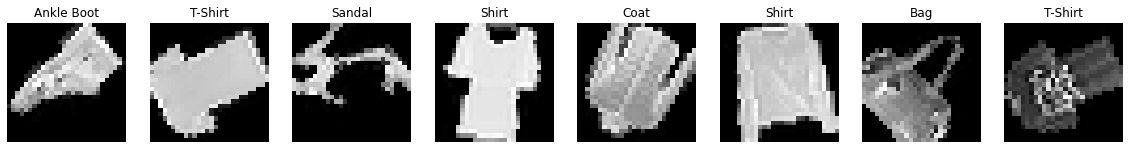

In [9]:
labels_data ={
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

fig = plt.figure(figsize=(20, 8))
cols, rows = 8,1

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_data[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [10]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Check Images Shape

In [11]:
for image, label in train_dataloader:
    break
image.shape

torch.Size([100, 1, 28, 28])

## Build Model

In [68]:
class Model(nn.Module):
  def __init__(self, in_channels=1):
    super(Model, self).__init__()

    self.model = models.mobilenet_v2(pretrained=True)
    # self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # num_ftrs = self.model.fc.in_features
    # self.model.fc = nn.Linear(num_ftrs, 10)
    self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    self.model.classifier[1] = nn.Linear(self.model.last_channel, 10)
    
  def forward(self, x):
    return self.model(x)

In [29]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training 

In [30]:
def train(num_epochs=5):
  train_loss = []
  train_accuracy = []

  val_loss = []
  val_accuracy = []

  predictions_list = []
  labels_list = []

  best_loss = .4
  best_accuracy = 0

  start = time.time()
  for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print('-' * 10)

    train_correct = 0
    val_correct = 0


    for X_train, y_train in train_dataloader:
      model.train()
      X_train, y_train = X_train.to(device), y_train.to(device)

      y_pred = model(X_train)
      loss = criterion(y_pred, y_train)

      predicted = torch.max(y_pred.data, 1)[1]
      train_correct += (predicted == y_train).sum()/data_size[0]

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss.append(loss.detach().cpu().numpy())
    train_accuracy.append(train_correct.detach().cpu().numpy())

    print(f'loss: {loss}\naccuracy: {train_correct}\n')

    with torch.no_grad():
      for X_test, y_test in validation_dataloader:
        model.eval()
        X_test, y_test = X_test.to(device), y_test.to(device)

        labels_list.append(y_test)

        y_val = model(X_test)

        predicted = torch.max(y_val.data, 1)[1]
        predictions_list.append(predicted)
        val_correct += (predicted == y_test).sum()/data_size[1]
    
    loss = criterion(y_val, y_test)
    val_loss.append(loss.detach().cpu().numpy())
    val_accuracy.append(val_correct.detach().cpu().numpy())
    print(f'val_loss: {loss}\nval_accuracy: {val_correct}\n\n')

    if best_accuracy < val_correct:
      if best_loss > loss:
        best_loss = loss
        best_accuracy = val_correct
        best_model = copy.deepcopy(model)

  end = time.time() - start

  print('-' * 10)
  print(f'Training time taken: {int(end/60)}min {int(end%60)}sec\n')
  print(f'Best val_accuracy: {best_accuracy}')
  print(f'Lowest val_loss: {best_loss}')

  return best_model, [train_loss, train_accuracy, val_loss, val_accuracy], [predictions_list, labels_list]

In [31]:
trained_model, result, preds_and_labels = train(50)

Epoch: 1/50
----------
loss: 0.7874244451522827
accuracy: 0.6372169852256775

val_loss: 0.8615039587020874
val_accuracy: 0.7061000466346741


Epoch: 2/50
----------
loss: 0.5416148900985718
accuracy: 0.7511345148086548

val_loss: 0.6538333892822266
val_accuracy: 0.750099778175354


Epoch: 3/50
----------
loss: 0.496999591588974
accuracy: 0.7846001386642456

val_loss: 0.6014500856399536
val_accuracy: 0.8020999431610107


Epoch: 4/50
----------
loss: 0.581447184085846
accuracy: 0.8039489984512329

val_loss: 0.5292623043060303
val_accuracy: 0.8011001348495483


Epoch: 5/50
----------
loss: 0.47667914628982544
accuracy: 0.818915843963623

val_loss: 0.509096086025238
val_accuracy: 0.8083997964859009


Epoch: 6/50
----------
loss: 0.36484554409980774
accuracy: 0.824849009513855

val_loss: 0.5031783580780029
val_accuracy: 0.825299859046936


Epoch: 7/50
----------
loss: 0.418602854013443
accuracy: 0.8370656371116638

val_loss: 0.5264605283737183
val_accuracy: 0.7917999029159546


Epoch: 8/50


## Model Evaluation

In [32]:
train_loss = result[0]
train_accuracy = result[1]

val_loss = result[2]
val_accuracy = result[3]

dictionary = {
    'train_loss':train_loss,
    'train_accuracy':train_accuracy,
    'val_loss':val_loss,
    'val_accuracy':val_accuracy
}
metrics = pd.DataFrame(dictionary)
metrics

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.78742445,0.637217,0.86150396,0.70610005
1,0.5416149,0.7511345,0.6538334,0.7500998
2,0.4969996,0.78460014,0.6014501,0.80209994
3,0.5814472,0.803949,0.5292623,0.80110013
4,0.47667915,0.81891584,0.5090961,0.8083998
5,0.36484554,0.824849,0.50317836,0.82529986
6,0.41860285,0.83706564,0.5264605,0.7917999
7,0.4057734,0.8444996,0.40959293,0.8326
8,0.33484116,0.8463984,0.46636495,0.8342999
9,0.38140473,0.8511659,0.45402294,0.8231997


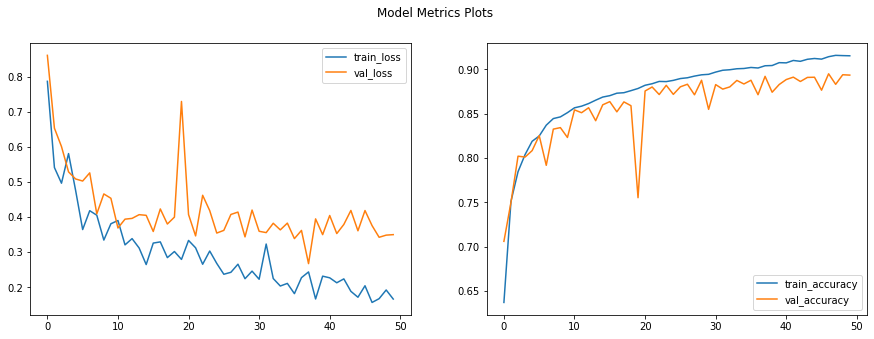

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Metrics Plots')

ax1.plot(metrics[['train_loss', 'val_loss']])
ax1.legend(['train_loss', 'val_loss'], loc="upper right")

ax2.plot(metrics[['train_accuracy', 'val_accuracy']])
ax2.legend(['train_accuracy', 'val_accuracy'], loc="lower right");

In [34]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in validation_dataloader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = trained_model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 82.00%
Accuracy of Trouser: 100.00%
Accuracy of Pullover: 85.11%
Accuracy of Dress: 88.04%
Accuracy of Coat: 82.24%
Accuracy of Sandal: 96.63%
Accuracy of Shirt: 69.70%
Accuracy of Sneaker: 94.90%
Accuracy of Bag: 98.11%
Accuracy of Ankle Boot: 99.09%


In [35]:
predictions_list = preds_and_labels[0]
labels_list = preds_and_labels[1]

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [36]:
print("Classification report for CNN :\n", classification_report(labels_l, predictions_l))

Classification report for CNN :
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     50000
           1       0.96      0.97      0.96     50000
           2       0.76      0.84      0.80     50000
           3       0.84      0.86      0.85     50000
           4       0.78      0.77      0.77     50000
           5       0.96      0.93      0.95     50000
           6       0.72      0.56      0.63     50000
           7       0.93      0.92      0.92     50000
           8       0.89      0.94      0.92     50000
           9       0.94      0.96      0.95     50000

    accuracy                           0.86    500000
   macro avg       0.86      0.86      0.86    500000
weighted avg       0.86      0.86      0.86    500000



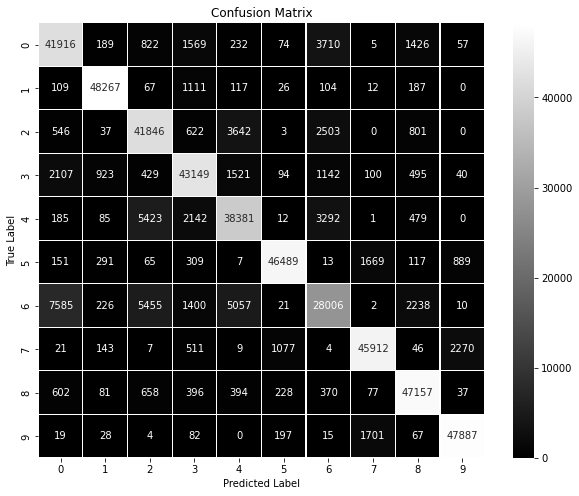

In [37]:
confusion_mtx = confusion_matrix(labels_l, predictions_l) 

f,ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Save Model

In [69]:
PATH = "mobilenetv2_model.pt"
torch.save(trained_model.state_dict(), PATH)

sirius_model = Model().to('cuda')
sirius_model.load_state_dict(torch.load(PATH))
sirius_model.eval()

Model(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), st

## Predict Custom Image

In [70]:
image_transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [71]:
def custom_image_pred(model, image_transforms, image_path, labels_data):
  image = Image.open(image_path)

  if image.mode == 'RGB':
    image = image.convert('L')
    image = ImageOps.invert(image)
  else:
    image = image.convert('L')

  resize_image = image.resize((128, 128))  
  
  image = image_transforms(image).float()
  image = image.unsqueeze(0).to(device)

  output = model(image)
  probs = F.softmax(output, dim=1)
  conf, classes = torch.max(probs, 1)

  return labels_data[classes.item()], round(conf.item(), 3), resize_image

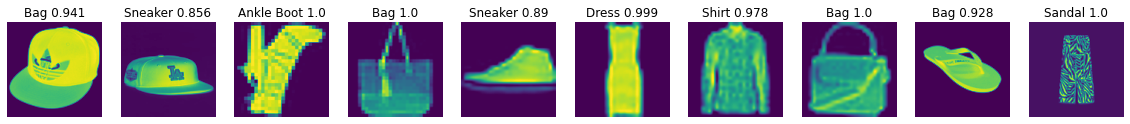

In [72]:
folder_dir = "/content/drive/MyDrive/test_image/"
image_list = []

for images in listdir(folder_dir):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      image_list.append(str(folder_dir+images))

fig = plt.figure(figsize=(20, 8))
cols, rows = len(image_list), 1

for i in range(1, cols * rows + 1):
    labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, image_list[i-1], labels_data)
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{labels_pred} {conf}')
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [74]:
# labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, '/content/Untitled3.png', labels_data)

# fig.add_subplot(rows, cols, i)
# plt.title(f'{labels_pred} {conf}')
# plt.axis('off')
# plt.imshow(image);